In [1]:
import numpy as np
import pandas as pd 
import heapq
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

In [2]:
np.random.seed(77)

### Limitations:
#### 1. No Abandments
#### 2. There is at least one field contractor available


### Initialization

In [7]:
class Event():
    def __init__(self, time, eventType, P , water_break= None): 
        self.time = time # event time
        self.eventType = eventType # type of the event
        self.water_break = water_break
        self.P = P
        heapq.heappush(self.P, self) #add the event to the events list

    def __lt__(self,event2):
        return self.time < event2.time
    
class Water_Break(object):
    def __init__(self, occurred_time, i ):
        self.occurred_time = occurred_time
        

            
        self.id = i
        
        self.valve_closed = False # By field supervisor
        self.step2_got_handled = False # Pinpointing the Location of the Leak By field contractor
        self.step3_got_handled = False # Excavating for Leak Exposure and water pumping By field contractor
        self.step4_got_handled = False # Evaluating the Pipe Damage and Leak By field contractor
        self.step5_got_handled = False # Providing and Compacting Proper Backfill Material By field contractor
        self.step6_got_handled = False # Performing Proper Site Restoration By field contractor


        
class Day_at_work(object):
    def __init__(self, chosen_sys_config, iter_id = 1):
        #Simulation params
        self.iter_id = iter_id
        self.curr_time = 0
        self.prev_time = 0
        self.P = []
        self.T = 10000
        self.L = []
        self.L_Time = 1000
        
        
        self.chosen_sys_config = chosen_sys_config
        
        self.water_break_counter = 0
        self.response_times = []
        self.poor_response_time_water_break_counter = 0
        self.stable_state_water_break_counter = 0
        self.truck_occupied = False
    

        #init the first break report
        Event(self.curr_time ,"leak or burst water pipe reported", self.P, water_break = Water_Break(self.curr_time,self.water_break_counter + 1)) 
        

### Measurements:

### Build simualtion

In [9]:
def run_simulation(chosen_sys_config, n_iters= 1):
    
    from numpy.random import SeedSequence, default_rng

    ss = SeedSequence(7)

    # Spawn off 2 child SeedSequences to pass to child processes.
    child_seeds = ss.spawn(2)
    streams = [default_rng(s) for s in child_seeds]
    
    occurrences_stream = streams[0]
    repairment_stream = streams[1]
    
    # Measurements
    total_response_times = np.array([])
    expected_response_time = [] #np.array([0]*100)
    poor_response_time_expectation = []
    
    for i in range(0, n_iters):

        
        sim = Day_at_work(chosen_sys_config = None, iter_id = i ) #, occurrences_stream = streams[0]
        
        
        while sim.curr_time < sim.T :
            
            
            sim.prev_time = sim.curr_time
            event = heapq.heappop(sim.P)
            sim.curr_time = event.time
            
                
            if event.eventType == "leak or burst water pipe reported" : 
                water_break = event.water_break
                sim.water_break_counter += 1
                
                heapq.heappush(sim.L, (event.water_break.occurred_time, water_break))
                
                
                if not sim.truck_occupied:
                    occurred_time ,_water_break = heapq.heappop(sim.L)
                    if np.random.uniform(0,1) <= 0.9:
                        x = np.random.uniform(5/60, 10/60)
                    else:
                        if not chosen_sys_config:
                            x = np.random.uniform(10/60, 2)
                        else:
                            x = np.random.uniform(10/60, 1)
#                     if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                         print(f"Water Break Wait Time: {x}: {sim.curr_time} - {sim.curr_time + x}")
                    Event(sim.curr_time + x , "Field Supervisor got called", sim.P, water_break=_water_break)
                else:
                    pass
#                     print("truck still occupied!")
                
                if sim.curr_time > sim.L_Time:
                    sim.stable_state_water_break_counter += 1

            #time for next occurrences
                if (sim.curr_time <= sim.T):
                    x = np.random.exponential(8860/300) # 1/lambda

                    Event(sim.curr_time + x ,"leak or burst water pipe reported", sim.P, Water_Break(sim.curr_time + x, sim.water_break_counter))
            
            elif event.eventType == "Field Supervisor got called" :
                sim.truck_occupied = True
#                 event.water_break.step1_got_handled = True
                x = np.random.uniform(15/60, 20/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Field Supervisor got called: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Pinpointing the Location of the Leak", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Pinpointing the Location of the Leak" :
#                 print("Location Pinpointed")
#                 print(len(sim.L))
                
                event.water_break.step2_got_handled = True
                x = np.random.uniform(10/60, 40/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Pinpointing the Location of the Leak: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Relevant valves closed", sim.P, water_break=event.water_break)
#                 else:
#                     print("**")
            
            elif event.eventType == "Relevant valves closed" :
#                 print("Relevant valves closed")
#                 sim.elevators[event.elevator].has_problem = False
                event.water_break.step2_got_handled = True
                x = np.random.uniform(20/60, 45/60)
#                 if i == 2000:
#                     print(f"Relevant valves closed: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Contractor got called", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Contractor got called" :
#                 sim.elevators[event.elevator].has_problem = False
#                 print("Contractor got called")
                if np.random.uniform(0,1) <= 0.85:
                    x = np.random.uniform(0.5, 45/60)
                else:
                    if not chosen_sys_config:
                        x = np.random.uniform(45/60, 2.5)
                    else:
                        x = np.random.uniform(45/60, 1.5)
#                 x = np.random.uniform(0.5, 240/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Contractor in his way: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Water Pump", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Water Pump" :
#                 sim.elevators[event.elevator].has_problem = False
#                 print("Water Pump")
                event.water_break.step3_got_handled = True
                x = np.random.uniform(5/60, 10/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Water Pumping: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time  + x ,"Pipe Damage and Leak Evaluated", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Pipe Damage and Leak Evaluated" :
#                 print("Pipe Damage and Leak Evaluated")
                event.water_break.step4_got_handled = True
                x = np.random.uniform(10/60, 15/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Pipe Damage and Leak Evaluating: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time  + x ,"Proper Backfill Material Provided", sim.P, water_break=event.water_break)
                
            elif event.eventType == "Proper Backfill Material Provided" :
#                 sim.elevators[event.elevator].has_problem = False
#                 print("Proper Backfill Material Provided")
                event.water_break.step5_got_handled = True
                if np.random.uniform(0,1) <= 0.8:
                    x = np.random.uniform(0.5, 1)
                else:
                    if not chosen_sys_config:
                        x = np.random.uniform(30/60, 2.5)
                    else:
                        x = np.random.uniform(30/60, 1.25)
#                 x = np.random.uniform(0.5, 240/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Providing Proper Backfill Material: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Service Ended", sim.P, water_break=event.water_break)
                
            elif event.eventType == "Service Ended" :
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Service Ended: {sim.curr_time - event.water_break.occurred_time}")
#                 event.water_break.step6_got_handled = True
                sim.truck_occupied = False
                event.water_break.step6_got_handled = True
        
            #Measurements
                if sim.curr_time > sim.L_Time:
                    sim.response_times.append(sim.curr_time - event.water_break.occurred_time)


                    if sim.curr_time - event.water_break.occurred_time > 4:
                        sim.poor_response_time_water_break_counter += 1
                
                if (len(sim.L) > 0):
#                     print(len(sim.L))
                    occurred_time ,water_break = heapq.heappop(sim.L)
#                     x = np.random.uniform(0.25, 0.45)
                    if np.random.uniform(0,1) <= 0.9:
                        x = np.random.uniform(5/60, 10/60)
                    else:
                        if not chosen_sys_config:
                            x = np.random.uniform(10/60, 2)
                        else:
                            x = np.random.uniform(10/60, 1)
#                     if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                         print(f"Water Break Wait Time: {x}: {sim.curr_time} - {sim.curr_time + x}")
                    Event(sim.curr_time + x  ,"Field Supervisor got called", sim.P, water_break=_water_break)
                else:
                    pass
#                     print("*")
                      
        

        sim_iters.append(sim)
        total_response_times = np.append(total_response_times, np.array(sim.response_times).reshape(-1,1))

        
        expected_response_time.append(np.array(sim.response_times).mean(dtype=np.float64))
        poor_response_time_expectation.append(sim.poor_response_time_water_break_counter/ sim.stable_state_water_break_counter)
#         print(expected_response_time)

    fig =plt.figure(figsize=((20,8)))
    ax1 = fig.add_subplot(111)
    ax1.set_title('Response time distribution')
    ax1.hist(total_response_times, bins=150, range=[0, 10], edgecolor='k')
    ax1.set(xlabel='Hours', ylabel='Counts')
    plt.tight_layout()
    plt.show()
    
#     print(poor_response_time_expectation)
    fig2, axs2 = plt.subplots(figsize=(16,4))
    axs2.scatter(x = range(n_iters), y = poor_response_time_expectation , label='poor_response_time_expectation', marker = 's')
    # Plot the average line
    y_mean = [np.mean(poor_response_time_expectation)]*n_iters
    axs2.plot(range(n_iters),y_mean, label='Mean', linestyle='--')
    axs2.set(xlabel='Simulation iters', ylabel='Expected poor_response_time')
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs2.text(0.05, 0.95, f"expected poor_response_time = {round(y_mean[0], 2)}" , transform=axs2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    axs2.set_title('Expected proportion of break repair with poor response time')
    plt.show()
   
    return(expected_response_time, poor_response_time_expectation)

### Run simualtion

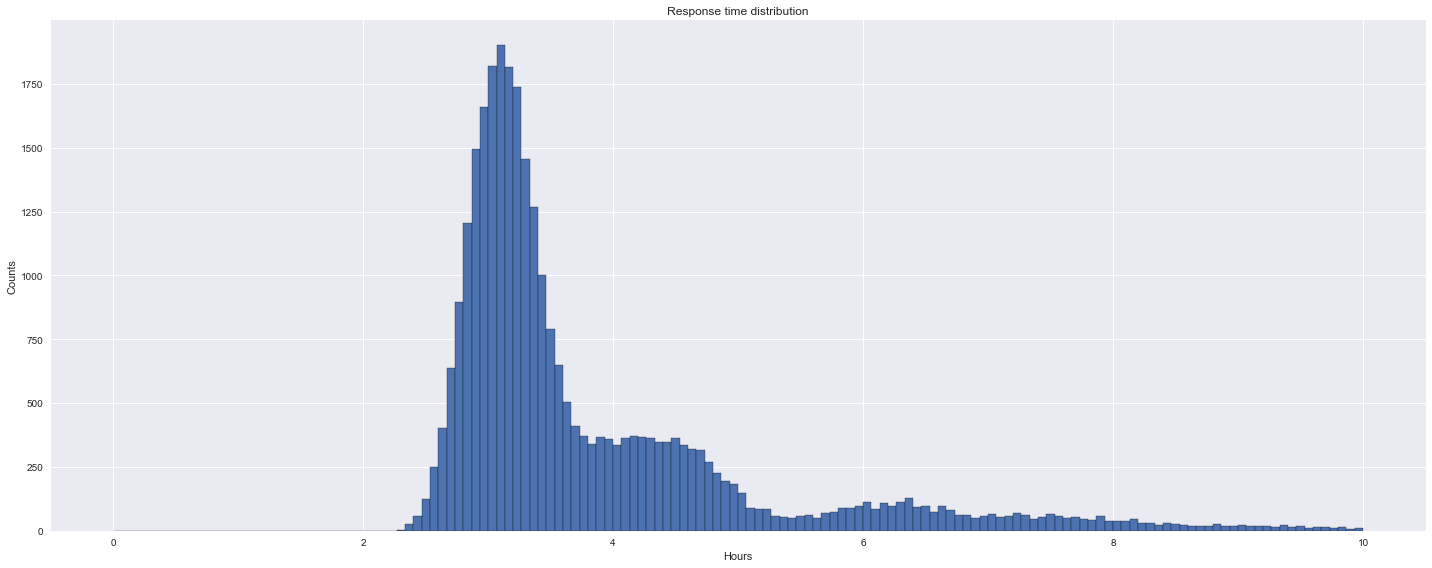

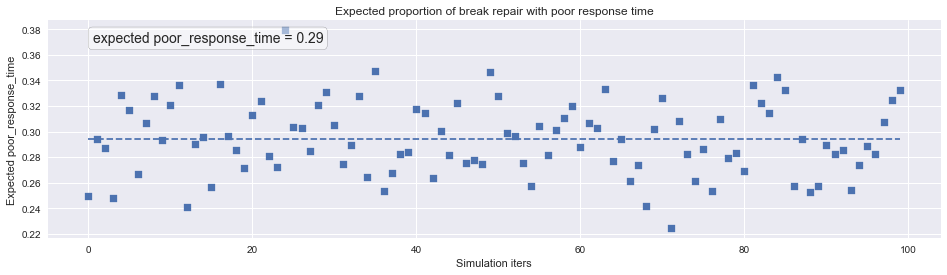

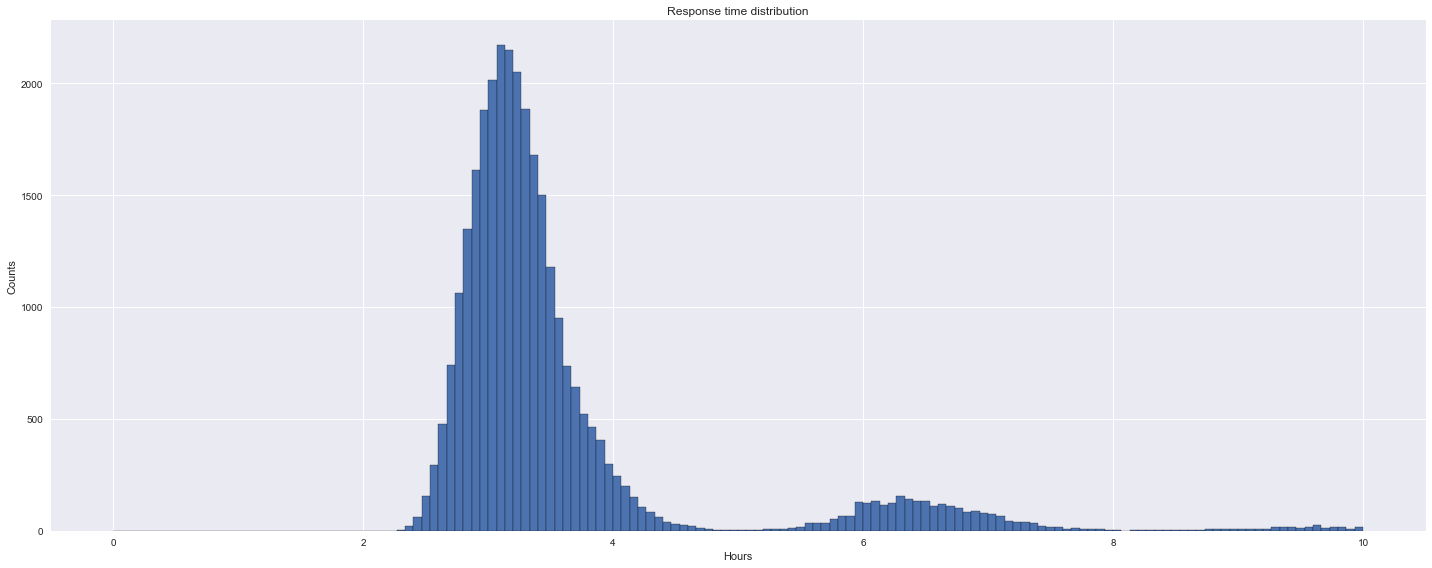

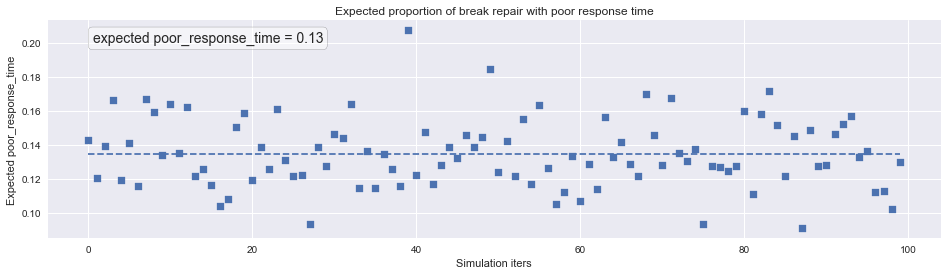

In [10]:
sim_iters = []
#System configurations; 0- Status quo    1- Our proposed solution
# sys_configurations = [0]
sys_configurations = [0,1]

config_measurements = {0: [], 
                       1: []
                       }

for config in sys_configurations:
    chosen_sys_config = config #sys_configurations[config]
#     days = []
    config_measurements[config] = run_simulation(config, n_iters= 100)
# config_measurements

### Ploting and visualization

In [21]:
config_measurements_df = pd.DataFrame(
                   columns=['states','expected_response_time', 'poor_response_time_expectation'])
# config_measurements_df

In [22]:
config_measurements_df['states'] = (["Current State"]*100)
config_measurements_df['expected_response_time'] = config_measurements[0][0]
config_measurements_df['poor_response_time_expectation'] = config_measurements[0][1]
# config_measurements_df

In [23]:
_sim_iters = list(range(100))
config_measurements_df['sim_iters'] = _sim_iters
# config_measurements_df

In [24]:
config_measurements_df2 = pd.DataFrame(
                   columns=['states','expected_response_time', 'poor_response_time_expectation'])
# config_measurements_df2
config_measurements_df2['states'] = (["Our proposed solution"]*100)
config_measurements_df2['expected_response_time'] = config_measurements[1][0]
config_measurements_df2['poor_response_time_expectation'] = config_measurements[1][1]
# config_measurements_df2

In [25]:
_sim_iters = list(range(100))
config_measurements_df2['sim_iters'] = _sim_iters
# config_measurements_df2

In [26]:
config_measurements_df = config_measurements_df.append(config_measurements_df2, ignore_index=True)

In [27]:
# config_measurements_df

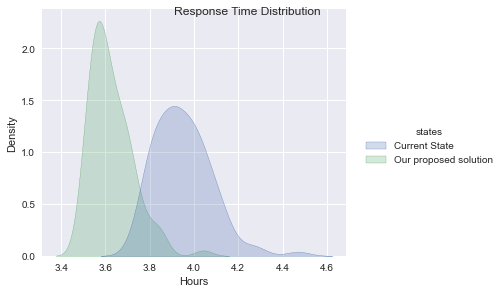

In [28]:
g = sns.displot(config_measurements_df, x="expected_response_time", hue="states", kind="kde", fill=True)
g.fig.suptitle('Response Time Distribution')
g.fig.set_figwidth(7)
g.fig.set_figheight(4)
plt.xlabel("Hours")
plt.show()

In [29]:
mean_config_measurements_df = config_measurements_df.groupby('states').mean()
y_mean = mean_config_measurements_df.poor_response_time_expectation.values

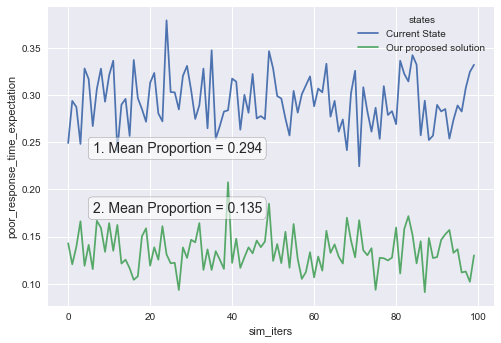

In [30]:
axs1 = sns.lineplot(x = 'sim_iters' , y="poor_response_time_expectation",
             hue="states",
             data=config_measurements_df)

props = dict(boxstyle='round', facecolor='white', alpha=0.6)
axs1.text(0.1, 0.55, f"1. Mean Proportion = {round(y_mean[0], 3)}" , transform=axs1.transAxes, fontsize=14,verticalalignment='top', bbox=props)
axs1.text(0.1, 0.35, f"2. Mean Proportion = {round(y_mean[1], 3)}" , transform=axs1.transAxes, fontsize=14,verticalalignment='top', bbox=props)

plt.show()